In [12]:
def contourPlot(x,y,u, val):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.contourf(x,y, u.T, levels=50, cmap='jet')
    plt.colorbar(label=val)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(0, .1)
    plt.title(f'Contour Plot of {val}')
    plt.show()

In [21]:
# Define grid size and initialize variables
Lx, Ly = 1.0, 0.1  # Domain dimensions
nx, ny = 100, 50  # Number of grid points in x and y directions
U_inf = 10.0  # Free-stream velocity
nu = 1e-3  # Kinematic viscosity

In [22]:
import numpy as np
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)

def EulerExplicitScheme():

    
    # Calculate grid spacing and time step
    dy = Ly / (ny - 1)
    dx = 0.5 * (dy**2) / (2* nu ) # Reduced dx for stability; CFL condition check
        
    # Boundary Conditions
    u[:, 0] = 0  # No-slip condition at the wall (bottom boundary)
    u[:, -1] = U_inf  # Inlet condition at the top edge (far-field boundary)
    v[:, 0] = 0  # No penetration at the wall (bottom)
    v[0, :] = 0  # No penetration at the leading edge

    for i in range(1, nx):
        un = u[i-1, :].copy()  # Store previous x-step values of u

        # Explicit update for u using the x-momentum equation
        for j in range(1, ny-1):
            # Convective term (adjusted sign and form for stability)
            convective_term = -v[i-1, j] * (un[j+1] - un[j-1]) / (2 * dy)
            
            # Diffusive term
            diffusive_term = nu * (un[j+1] - 2 * un[j] + un[j-1]) / dy**2
            
            # Update u using explicit scheme
            u[i, j] = un[j] + dx * (convective_term + diffusive_term)
        
        # Update v using continuity equation to ensure mass conservation
        for j in range(1, ny):
            v[i, j] = v[i-1, j] - (dx / dy) * (u[i, j] - u[i-1, j])

        # Reapply boundary conditions after update
        u[i, 0] = 0  # No-slip condition at the wall
        u[i, -1] = U_inf  # Inlet condition at the top edge
    
    return u, v

# Run the Euler Explicit scheme
u, v, = EulerExplicitScheme()

# To visualize or further analyze u, v fields, you can add plotting code here.


C:\Users\Vardan\AppData\Local\Temp\ipykernel_9584\1945991860.py:24: RuntimeWarning: overflow encountered in scalar multiply
  convective_term = -v[i-1, j] * (un[j+1] - un[j-1]) / (2 * dy)
C:\Users\Vardan\AppData\Local\Temp\ipykernel_9584\1945991860.py:30: RuntimeWarning: invalid value encountered in scalar add
  u[i, j] = un[j] + dx * (convective_term + diffusive_term)
C:\Users\Vardan\AppData\Local\Temp\ipykernel_9584\1945991860.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  convective_term = -v[i-1, j] * (un[j+1] - un[j-1]) / (2 * dy)
C:\Users\Vardan\AppData\Local\Temp\ipykernel_9584\1945991860.py:27: RuntimeWarning: invalid value encountered in scalar subtract
  diffusive_term = nu * (un[j+1] - 2 * un[j] + un[j-1]) / dy**2
C:\Users\Vardan\AppData\Local\Temp\ipykernel_9584\1945991860.py:27: RuntimeWarning: invalid value encountered in scalar add
  diffusive_term = nu * (un[j+1] - 2 * un[j] + un[j-1]) / dy**2


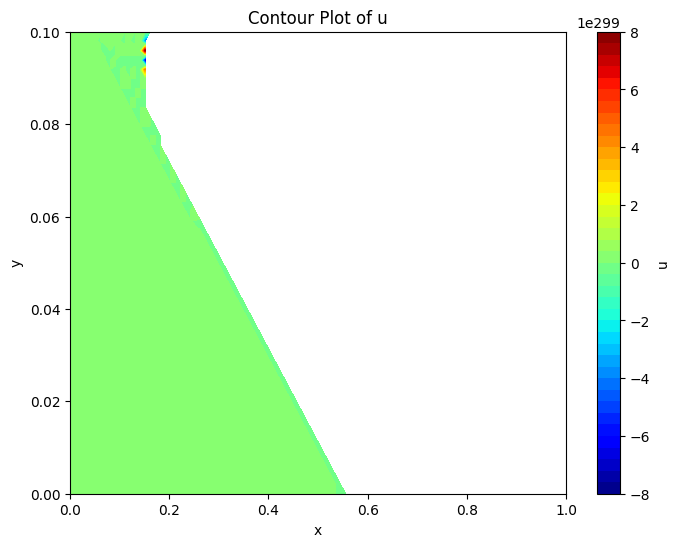

In [23]:
contourPlot(x,y,u,'u')

In [24]:
import numpy as np

def CrankNicolsonScheme():
    # Define grid size and initialize variables
    Lx, Ly = 1.0, 0.1  # Domain dimensions
    nx, ny = 100, 50  # Number of grid points in x and y directions
    dx = Lx / (nx - 1)
    dy = Ly / (ny - 1)
    U_inf = 1.0 
    nu = 1e-3  # Kinematic viscosity

    # Initialize u and v velocities
    u = np.ones((nx, ny)) * U_inf
    v = np.zeros((nx, ny))
    
    # Boundary Conditions
    u[:, 0] = 0  # No-slip condition at the wall
    u[:, -1] = U_inf  # Inlet condition at the top edge
    v[:, 0] = 0  # No penetration at the wall (bottom)
    v[0, :] = 0  # No penetration at the leading edge

    for i in range(1, nx):
        u[i, :] = u[i-1, :]
        
        for _ in range(1000):
            A_lower = np.zeros(ny-1)
            A_main = np.zeros(ny)
            A_upper = np.zeros(ny-1)
            b = np.zeros(ny)

            for j in range(1, ny-1):
                # Crank-Nicolson Coefficients
                A_lower[j-1] = -nu / (2 * dy**2) + v[i,j] / (4 * dy)
                A_main[j] = 1 / dx + nu / (dy**2)
                A_upper[j] = -nu / (2 * dy**2) - v[i,j] / (4 * dy)
                b[j] = u[i-1, j] / dx + (u[i, j+1] - 2 * u[i, j] + u[i, j-1]) * nu / (2 * dy**2)

            # Boundary conditions
            A_main[0] = 1  # Dirichlet boundary condition at bottom wall
            b[0] = 0       # No-slip condition
            A_main[-1] = 1 # Dirichlet boundary condition at top wall
            b[-1] = U_inf  # Inlet condition
            
            # Solve for new u values using TDMA
            u_new = tdma_solver(A_lower, A_main, A_upper, b)
            
            # Check for convergence
            if np.linalg.norm(u_new - u[i, :]) < 1e-6:
                u[i, :] = u_new
                break
            u[i, :] = u_new

        # Update v using continuity equation
        for j in range(1, ny):
            v[i, j] = v[i, j-1] - dy/dx * (u[i, j] - u[i-1, j])

    # Create grid for plotting

    
    return u, v, x, y

def tdma_solver(a, b, c, d):
    n = len(b)
    c_star = np.zeros(n-1)
    d_star = np.zeros(n)
    
    # Forward sweep
    c_star[0] = c[0] / b[0]
    d_star[0] = d[0] / b[0]
    for i in range(1, n-1):
        c_star[i] = c[i] / (b[i] - a[i-1] * c_star[i-1])
    for i in range(1, n):
        d_star[i] = (d[i] - a[i-1] * d_star[i-1]) / (b[i] - a[i-1] * c_star[i-1])
    
    # Backward substitution
    x = np.zeros(n)
    x[-1] = d_star[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_star[i] - c_star[i] * x[i+1]
    
    return x

# Run the Crank-Nicolson scheme
u, v, x, y = CrankNicolsonScheme()


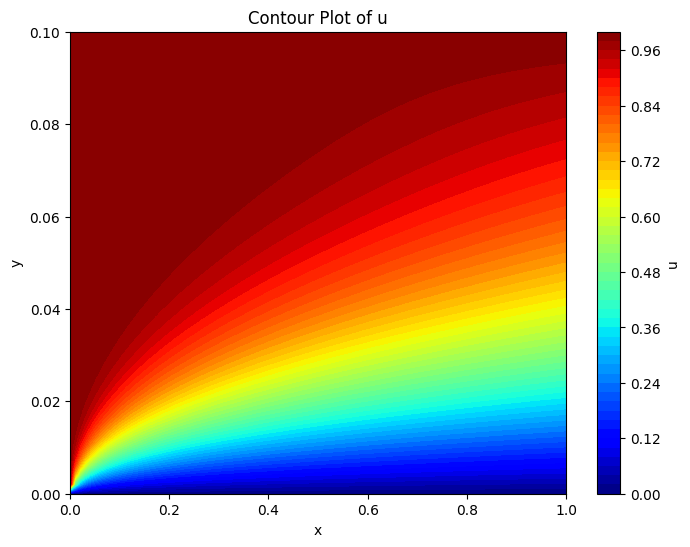

In [25]:
contourPlot(x,y,u,'u')